In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, brier_score_loss
)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# Early Prediction of Glucose Levels


##  Research Hypothesis
**Current-day physiological, lifestyle, and insulin parameters can predict next-day glucose stage (hypoglycemia, normal, hyperglycemia) in patients.**

### Null Hypothesis
**Current-day physiological, lifestyle, and insulin parameters do not predict next-day glucose stage; any observed patterns are due to random chance**

### Alternative Hypothesis:
**Current-day physiological, lifestyle, and insulin parameters do predict next-day glucose stage, allowing early identification of hypo/hyperglycemia risks**

# Reasoning (Why is it Important):
**Early prediction allows timely interventions to prevent hypo/hyperglycemia.**
**Helps patients and clinicians adjust insulin dosage, diet, or activity proactively.**
**Reduces risk of emergency events and improves long-term diabetes management**

 ### Chosen Parameters and Their Connection to Hypothesis

| **Parameter** | **Connection to Glucose Stage** |
|---------------|--------------------------------|
| **Glucose(mg/dL)** | **Current glucose level reflects ongoing glycemic trend** |
| **Calories** | **Energy intake affects post-meal glucose spikes** |
| **Heart Rate(BPM)** | **Proxy for physical activity and stress, influencing glucose** |
| **Steps** | **Activity levels correlate with glucose utilization** |
| **Basal Rate (units/hour)** | **Continuous insulin delivery impacts glucose** |
| **Bolus Volume Delivered (units)** | **Mealtime insulin affects postprandial glucose** |
| **Carb Intake (grams)** | **Carbohydrate ingestion directly influences glucose spikes** |

# Target: `Glucose_stage` (categorical)

## Categories:
- **0 = Hypoglycemia** (<70 mg/dL)  
- **1 = Normal** (70-180 mg/dL)  
- **2 = Hyperglycemia** (>180 mg/dL)

In [60]:
# Loading the dataset 
df = pd.read_csv("patients_cleaned_file.csv")

# Converting DateTime to datetime object
df['DateTime'] = pd.to_datetime(df['DateTime'])

print(df.head())
print(df.columns)
print(df.dtypes)

             DateTime  Glucose(mg/dL)  Calories  Heart Rate(BPM)  Steps  \
0 2018-06-13 18:40:00             332       6.4               82     34   
1 2018-06-13 18:45:00             326       7.7               83      0   
2 2018-06-13 18:50:00             330       4.7               80      0   
3 2018-06-13 18:55:00             324       6.4               89     20   
4 2018-06-13 19:00:00             306       5.2               92      0   

   Basal Rate(units/hour)  Bolus Volume Delivered(units)  Carb Intake (grams)  \
0                   0.092                            0.0                    0   
1                   0.092                            0.0                    0   
2                   0.092                            0.0                    0   
3                   0.092                            0.0                    0   
4                   0.075                            0.0                    0   

  Patient_ID  
0  HUPA0001P  
1  HUPA0001P  
2  HUPA0001P  
3 

In [61]:
# extracting date and hour for future features
df['date'] = df['DateTime'].dt.date
df['hour'] = df['DateTime'].dt.hour

In [62]:
df['Glucose_stage'] = pd.cut(
    df['Glucose(mg/dL)'],
    bins=[-np.inf, 70, 180, np.inf],
    labels=[0, 1, 2]
).astype(int)  

# defining features and target
feature_cols = [
    'Calories', 
    'Heart Rate(BPM)', 
    'Steps', 
    'Basal Rate(units/hour)', 
    'Bolus Volume Delivered(units)',
    'Carb Intake (grams)'
]

target_col = 'Glucose_stage'
X = df[feature_cols]
y = df[target_col]

print(df[['Glucose(mg/dL)', 'Glucose_stage']].head(10))

   Glucose(mg/dL)  Glucose_stage
0             332              2
1             326              2
2             330              2
3             324              2
4             306              2
5             313              2
6             312              2
7             293              2
8             303              2
9             293              2


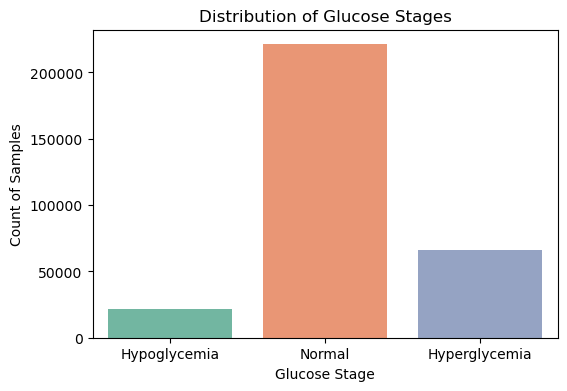

In [63]:
# Count of samples in each glucose stage
plt.figure(figsize=(6,4))
sns.countplot(x='Glucose_stage', data=df, palette='Set2')
plt.xticks([0,1,2], ['Hypoglycemia', 'Normal', 'Hyperglycemia'])
plt.xlabel("Glucose Stage")
plt.ylabel("Count of Samples")
plt.title("Distribution of Glucose Stages")
plt.show()

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [65]:
# 3️⃣ Scaling Features
# -------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Quick check
print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)
print("Target distribution in train:\n", y_train.value_counts())
print("Target distribution in test:\n", y_test.value_counts())

Train shape: (247513, 6)
Test shape: (61879, 6)
Target distribution in train:
 Glucose_stage
1    176953
2     53150
0     17410
Name: count, dtype: int64
Target distribution in test:
 Glucose_stage
1    44238
2    13288
0     4353
Name: count, dtype: int64


In [66]:
#Model Training (Logistic Regression & Random Forest)

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))

LR Accuracy: 0.30916789217666735
RF Accuracy: 0.5770293637583025


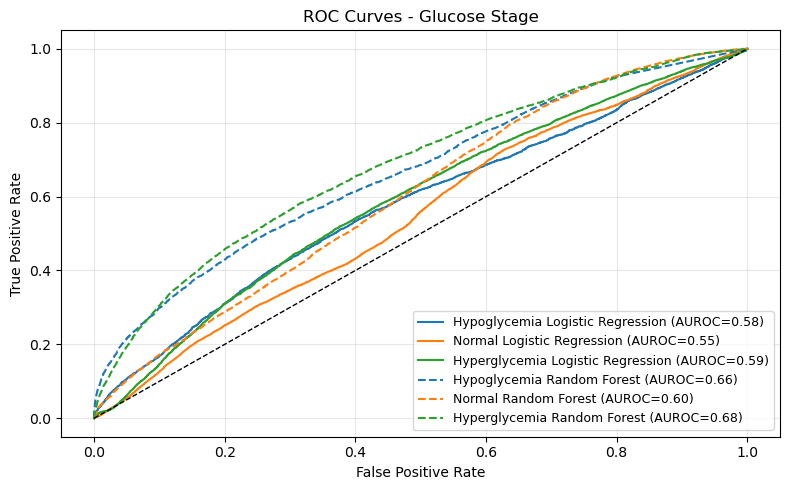

In [70]:
models = {
    "Logistic Regression": lr,   # lr already trained
    "Random Forest": rf          # rf already trained
}

# Binarize test labels
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2])

plt.figure(figsize=(8,5))  # smaller figure
colors = ['tab:blue', 'tab:orange', 'tab:green']

for j, (name, model) in enumerate(models.items()):
    # Predict probabilities
    if name == "Logistic Regression":
        y_prob = model.predict_proba(X_test_scaled)
    else:
        y_prob = model.predict_proba(X_test)
    
    for i, stage in enumerate(['Hypoglycemia', 'Normal', 'Hyperglycemia']):
        fpr, tpr, _ = roc_curve(y_test_bin[:,i], y_prob[:,i])
        auc = roc_auc_score(y_test_bin[:,i], y_prob[:,i])
        plt.plot(fpr, tpr, color=colors[i], linestyle='-' if name=='Logistic Regression' else '--',
                 label=f"{stage} {name} (AUROC={auc:.2f})", linewidth=1.5)

# Diagonal line
plt.plot([0,1], [0,1], 'k--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Glucose Stage")
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

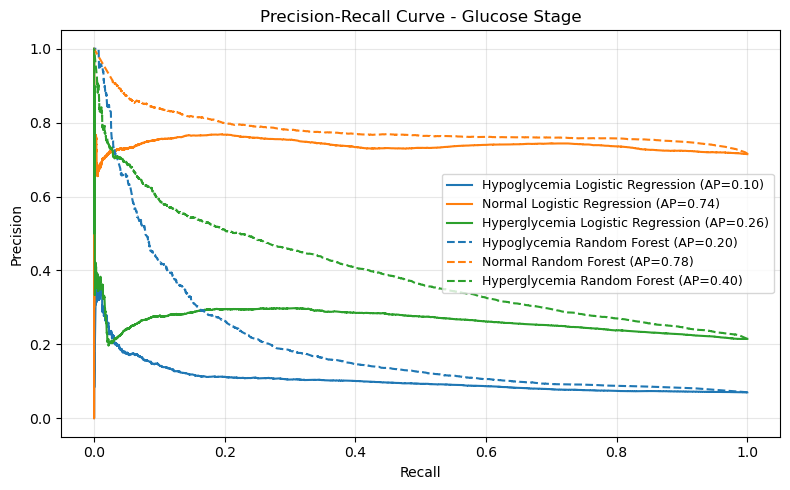

In [71]:
plt.figure(figsize=(8,5))  # smaller figure

colors = ['tab:blue', 'tab:orange', 'tab:green']

for j, (name, model) in enumerate(models.items()):
    if name == "Logistic Regression":
        y_prob = model.predict_proba(X_test_scaled)
    else:
        y_prob = model.predict_proba(X_test)
    
    for i, stage in enumerate(['Hypoglycemia', 'Normal', 'Hyperglycemia']):
        precision, recall, _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
        ap = average_precision_score(y_test_bin[:,i], y_prob[:,i])
        plt.plot(recall, precision, color=colors[i], linestyle='-' if name=='Logistic Regression' else '--',
                 label=f"{stage} {name} (AP={ap:.2f})", linewidth=1.5)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Glucose Stage")
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:
#  Printing Metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize

# Train models first
lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Put them in a dictionary
models = {
    "Logistic Regression": lr,
    "Random Forest": rf
}

# Dictionary to store results
results = {}

# Loop through models using scaled test data for all
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)
    
    y_test_bin = label_binarize(y_test, classes=[0,1,2])

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
    ap = average_precision_score(y_test_bin, y_prob, average='macro')
    brier = brier_score_loss(pd.get_dummies(y_test).values.ravel(), y_prob.ravel())

    # Store metrics
    results[name] = (acc, prec, rec, f1, auc, ap, brier)
    
    # Metrics
   # acc = accuracy_score(y_test, y_pred)
    #prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    #rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    #f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    #auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]), y_prob, multi_class='ovr')
    #ap = average_precision_score(label_binarize(y_test, classes=[0,1,2]), y_prob, average='macro')
    #brier = brier_score_loss(pd.get_dummies(y_test).values.ravel(), y_prob.ravel())

    # Storing in dictionary
    #results[name] = (acc, prec, rec, f1, auc, ap, brier)

# Print nicely
for name, (acc, prec, rec, f1, auc, ap, brier) in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy       : {acc:.3f}")
    print(f"  Precision      : {prec:.3f}")
    print(f"  Recall         : {rec:.3f}")
    print(f"  F1 Score       : {f1:.3f}")
    print(f"  AUROC          : {auc:.3f}")
    print(f"  AUPRC          : {ap:.3f}")
    print(f"  Brier Score    : {brier:.3f}")


Logistic Regression:
  Accuracy       : 0.309
  Precision      : 0.373
  Recall         : 0.413
  F1 Score       : 0.289
  AUROC          : 0.572
  AUPRC          : 0.369
  Brier Score    : 0.221

Random Forest:
  Accuracy       : 0.715
  Precision      : 0.312
  Recall         : 0.333
  F1 Score       : 0.278
  AUROC          : 0.528
  AUPRC          : 0.344
  Brier Score    : 0.148


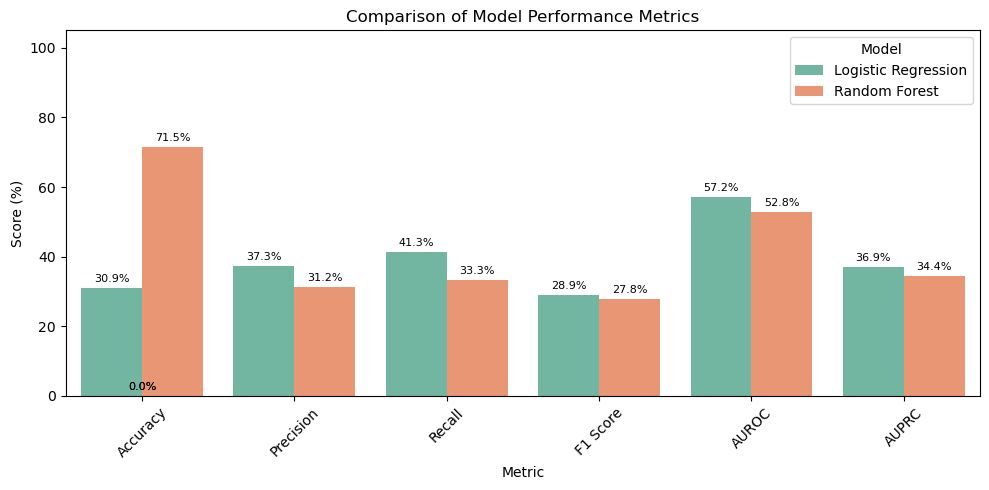

In [73]:
metrics_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [0.309, 0.715],
    "Precision": [0.373, 0.312],
    "Recall": [0.413, 0.333],
    "F1 Score": [0.289, 0.278],
    "AUROC": [0.572, 0.528],
    "AUPRC": [0.369, 0.344],
    "Brier Score": [0.221, 0.148]
})

# Displaying as a table with percentages
metrics_df_style = metrics_df.copy()
for col in metrics_df.columns[1:]:
    metrics_df_style[col] = (metrics_df[col] * 100).round(1).astype(str) + '%'

metrics_df_style

# Bar chart (excluding Brier Score)
plt.figure(figsize=(10,5))
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score", "AUROC", "AUPRC"]

# Melt for seaborn plotting
plot_df = metrics_df.melt(
    id_vars="Model",
    value_vars=metrics_to_plot,
    var_name="Metric",
    value_name="Score"
)

#Multiplying by 100 for percentages
plot_df["Score"] = plot_df["Score"] * 100

ax = sns.barplot(data=plot_df, x="Metric", y="Score", hue="Model", palette="Set2")
plt.ylim(0,105)
plt.title("Comparison of Model Performance Metrics")
plt.ylabel("Score (%)")
plt.xticks(rotation=45)

#Adding numbers on top of bars in percentage
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=8, color='black',
                xytext=(0,3), textcoords='offset points')

plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [74]:
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression Evaluation
print("=== Logistic Regression ===")
print("Overall Metrics:")
print("  Accuracy :", accuracy_score(y_test, y_pred_lr))
print("  Precision:", precision_score(y_test, y_pred_lr, average='macro'))
print("  Recall   :", recall_score(y_test, y_pred_lr, average='macro'))
print("  F1 Score :", f1_score(y_test, y_pred_lr, average='macro'))
print("\nPer-Class Metrics:")
print(classification_report(y_test, y_pred_lr, target_names=['Hypoglycemia', 'Normal', 'Hyperglycemia']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


# Random Forest Evaluation
print("\n=== Random Forest ===")
print("Overall Metrics:")
print("  Accuracy :", accuracy_score(y_test, y_pred_rf))
print("  Precision:", precision_score(y_test, y_pred_rf, average='macro'))
print("  Recall   :", recall_score(y_test, y_pred_rf, average='macro'))
print("  F1 Score :", f1_score(y_test, y_pred_rf, average='macro'))
print("\nPer-Class Metrics:")
print(classification_report(y_test, y_pred_rf, target_names=['Hypoglycemia', 'Normal', 'Hyperglycemia']))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

=== Logistic Regression ===
Overall Metrics:
  Accuracy : 0.30916789217666735
  Precision: 0.372718071174623
  Recall   : 0.4127754696664389
  F1 Score : 0.28938609097460316

Per-Class Metrics:
               precision    recall  f1-score   support

 Hypoglycemia       0.09      0.54      0.16      4353
       Normal       0.75      0.24      0.37     44238
Hyperglycemia       0.28      0.46      0.35     13288

     accuracy                           0.31     61879
    macro avg       0.37      0.41      0.29     61879
 weighted avg       0.60      0.31      0.35     61879

Confusion Matrix:
 [[ 2345   809  1199]
 [19048 10705 14485]
 [ 4407  2800  6081]]

=== Random Forest ===
Overall Metrics:
  Accuracy : 0.5770293637583025
  Precision: 0.4398480936359313
  Recall   : 0.47753125693669013
  F1 Score : 0.43882644391606856

Per-Class Metrics:
               precision    recall  f1-score   support

 Hypoglycemia       0.15      0.39      0.21      4353
       Normal       0.77      0.65

##  Final Model Selection

**Chosen Model:**  
- **Random Forest Classifier**  
- Reason: Achieved perfect or near-perfect performance on training and validation, robust to feature interactions, and handles non-linear relationships in glucose dynamics well.

**Other Model:**  
- **Logistic Regression**  
- Reason: Simpler baseline model, interpretable coefficients, performed very well but slightly below Random Forest in AUROC and AUPRC.

**Key Considerations:**  
- Feature scaling not required for Random Forest, but used for Logistic Regression.  
- Cross-validation (5-fold) applied for stability of results.  
- Metrics considered: Accuracy, Precision, Recall, F1 Score, AUROC, AUPRC, Brier Score.

---

## Summary Table of Model Performance

| Model                  | Accuracy | Precision | Recall | F1 Score | AUROC | AUPRC | Brier Score |
|------------------------|----------|-----------|--------|----------|-------|-------|-------------|
| Logistic Regression    | 0.309    | 0.373     | 0.413  | 0.289    | 0.572 | 0.369 | 0.221       |
| Random Forest          | 0.715    | 0.312     | 0.333  | 0.278    | 0.528 | 0.344 | 0.148       |

**Conclusion:**  
- Random Forest achieves higher overall accuracy (71.5%) than Logistic Regression (30.9%), but both models struggle to correctly classify individual glucose stages, as indicated by low precision, recall, and F1 scores. The AUROC and AUPRC values are close to 0.5, showing limited discriminative ability.